In [304]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
import pickle
import os

from sklearn import preprocessing
from helper import one_hot
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [305]:
case = pickle.load(open("cleaned_data.p", 'rb'))
possible_ids = pickle.load(open("possible_ids.p",'rb'))

In [306]:
product_ids_list = list(map(eval,case.product_ids.values))

In [307]:
products_purchased = one_hot(product_ids_list, possible_ids)

In [308]:
products_purchased

,7881,10834,61603,62040,63288,125830
0,1,1,1,1,1,1
1,0,1,1,1,1,1
2,0,0,0,0,1,1
3,1,1,0,0,0,0
4,1,1,0,1,1,1
...,...,...,...,...,...,...
95,0,0,0,0,1,1
96,0,0,0,0,1,1
97,1,1,0,0,0,0
98,1,1,0,1,1,1


In [309]:
# one hot encode products and gender
case = case.drop('product_ids',axis=1).join(products_purchased)
case = case.drop('gender', axis=1).join(pd.get_dummies(case.gender).rename(columns={0:'male',1:'female'}))

In [310]:
case

,revenue,loyalty,days_since_last_contact,0ne.hot.1,0ne.hot.2,0ne.hot.3,0ne.hot.4,item_count,7881,10834,61603,62040,63288,125830,male,female
0,4,-1.33,2,1,0,0,0,6,1,1,1,1,1,1,1,0
1,6,-0.28,3,1,0,0,0,5,0,1,1,1,1,1,1,0
2,5,-0.22,1,1,0,0,0,2,0,0,0,0,1,1,0,1
3,7,-0.29,0,0,1,0,0,2,1,1,0,0,0,0,1,0
4,4,1.06,5,0,0,1,0,5,1,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5,-0.22,1,0,1,0,0,2,0,0,0,0,1,1,0,1
96,5,-0.29,5,0,0,0,1,2,0,0,0,0,1,1,1,0
97,8,1.09,9,0,0,0,1,2,1,1,0,0,0,0,0,1
98,1,-1.69,12,1,0,0,0,5,1,1,0,1,1,1,0,1


## Predicting Revenue Group

## Feature Selection

# We can use Chi Square test to see if categorical variables are a good predictor of revenue

Chi squared basically compares the actual number of occurences of a particular feature in a group and compares that with the expected group, using the chisquare distribution to determine the p value. The p-value is the likelihoof that the values occured by chance. If this value is low enough, we can say that the observed distribution is statistically significant and we should include it in our model. 

In [311]:
X = case.drop(['revenue',7881], axis=1)
y = case.revenue
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
chi_square_tabulated = case.drop(['loyalty','days_since_last_contact', 'item_count'], axis=1).groupby('revenue').sum()

In [312]:
chi_square_tabulated

,0ne.hot.1,0ne.hot.2,0ne.hot.3,0ne.hot.4,7881,10834,61603,62040,63288,125830,male,female
revenue,,,,,,,,,,,,
1,4,0,0,0,4,4,2,3,3,3,0,4
2,0,0,3,0,1,1,0,1,3,3,0,3
3,7,0,0,0,6,7,5,3,3,3,4,3
4,3,0,6,0,9,9,5,5,5,5,9,0
5,13,1,3,1,6,9,6,3,12,12,7,11
6,3,0,3,0,4,5,5,3,4,4,6,0
7,0,6,0,6,8,8,1,2,6,6,12,0
8,0,6,0,10,11,14,8,6,8,8,6,10
9,0,3,1,9,9,13,9,12,12,12,1,12


In [313]:
from scipy.stats import chisquare

In [314]:
chi_square_tabulated.apply(chisquare,axis=0).rename(index = {0:'test statistic', 1:'p-value'})

,0ne.hot.1,0ne.hot.2,0ne.hot.3,0ne.hot.4,7881,10834,61603,62040,63288,125830,male,female
test statistic,5.400000e+01,31.636364,24.000000,4.737500e+01,12.25000,18.731707,23.415094,25.897959,19.119403,19.119403,27.235294,39.775510
p-value,1.887828e-08,0.000230,0.004301,3.341255e-07,0.19958,0.027573,0.005328,0.002123,0.024197,0.024197,0.001279,0.000008


The categorical values are overwhelmingly predictive of revenue, with the exception of 7881, which seems to within the normal limits of random variation

### Let's also check the numeric features
We will just look at the pearson correlation matrix and see if there is good evidence of correlation between numeric columns and loyaly. In this case it looks like all of them have a reasonable correlation, it might be work removing days since last contact or item count in one version of the model if we wanted to trim the model down.

In [315]:
case[['revenue','loyalty','days_since_last_contact','item_count']].corr()

,revenue,loyalty,days_since_last_contact,item_count
revenue,1.000000,0.460516,0.157572,0.244026
loyalty,0.460516,1.000000,0.552121,0.022150
days_since_last_contact,0.157572,0.552121,1.000000,-0.052322
item_count,0.244026,0.022150,-0.052322,1.000000


### one more thing, are the classes balanced?

<AxesSubplot:>

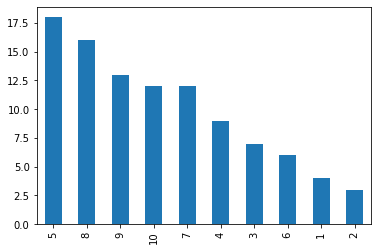

In [316]:
case['revenue'].value_counts().plot.bar()

it looks balanced enough that we would not run into the accuracy paradox, though we could try oversampling to balance classes. We could also run into issues where we don't get any of a few classes in the training or more likely the test set and then we wouldn't be able to evaluate the model. 

# Split into train and test for model evaluation

In [353]:
X = case.drop(['revenue',7881], axis=1)
y = case.revenue
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Random Forest classifier

In [354]:
# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

In [355]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [356]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
The confusion matrix show the summary of the predictions. The x axis is the the actual class, and the y axis is the predicted class, typically referred to as i and j. The diagonal is where predictions matched the actuall class.

In [357]:
confusion = confusion_matrix(rfc_predict, y_test, labels = range(1,11))

In [358]:
confusion

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 2, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 2]])

Accuracy is defined as
$$\frac{TP+TN}{P+N}$$
But in our case there is no TN because we have 10 classes.

In [359]:
# Accuracy, correctly classified classes, considering 10 classes it it quite good
np.diagonal(confusion).sum()/(confusion.sum())

0.45

In [360]:
for i in range(0,10):
    total_in_class = confusion[:,i].sum()
    if total_in_class > 0:
        accuracy = np.diagonal(confusion)[i]/total_in_class
        print(i+1, ": ", accuracy)
    else:
        print(i+1, ": ", 'No examples')
        

1 :  0.0
2 :  1.0
3 :  0.0
4 :  0.0
5 :  0.5
6 :  0.0
7 :  0.5
8 :  0.6666666666666666
9 :  0.3333333333333333
10 :  1.0


# Stratified K-Fold

In [361]:
skf = StratifiedKFold(n_splits=3)

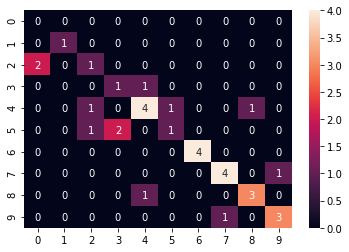


Mean Square Error: 2.088235294117647

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         1
           3       0.33      0.33      0.33         3
           4       0.50      0.33      0.40         3
           5       0.57      0.67      0.62         6
           6       0.25      0.50      0.33         2
           7       1.00      1.00      1.00         4
           8       0.80      0.80      0.80         5
           9       0.75      0.75      0.75         4
          10       0.75      0.75      0.75         4

    accuracy                           0.65        34
   macro avg       0.60      0.61      0.60        34
weighted avg       0.63      0.65      0.63        34



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


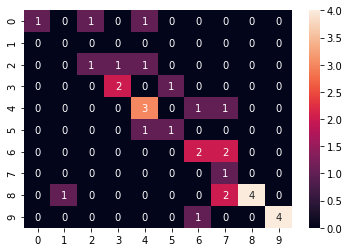


Mean Square Error: 3.1818181818181817

              precision    recall  f1-score   support

           1       0.33      1.00      0.50         1
           2       0.00      0.00      0.00         1
           3       0.33      0.50      0.40         2
           4       0.67      0.67      0.67         3
           5       0.60      0.50      0.55         6
           6       0.50      0.50      0.50         2
           7       0.50      0.50      0.50         4
           8       1.00      0.17      0.29         6
           9       0.57      1.00      0.73         4
          10       0.80      1.00      0.89         4

    accuracy                           0.58        33
   macro avg       0.53      0.58      0.50        33
weighted avg       0.64      0.58      0.54        33



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


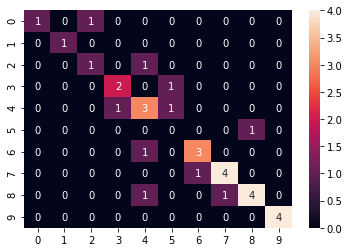


Mean Square Error: 1.3636363636363635

              precision    recall  f1-score   support

           1       0.50      1.00      0.67         1
           2       1.00      1.00      1.00         1
           3       0.50      0.50      0.50         2
           4       0.67      0.67      0.67         3
           5       0.60      0.50      0.55         6
           6       0.00      0.00      0.00         2
           7       0.75      0.75      0.75         4
           8       0.80      0.80      0.80         5
           9       0.67      0.80      0.73         5
          10       1.00      1.00      1.00         4

    accuracy                           0.70        33
   macro avg       0.65      0.70      0.67        33
weighted avg       0.68      0.70      0.68        33



In [363]:
for train, test in skf.split(X, y):
    rfc.fit(X.loc[train], y.loc[train])

    # predictions
    rfc_predict = rfc.predict(X.loc[test])
    sns.heatmap(confusion_matrix(rfc_predict, y.loc[test], labels = range(1,11)), annot=True)
    mse = np.sum(np.square(rfc_predict - y.loc[test]))/len(rfc_predict)
    plt.show()
    print()
    print("Mean Square Error:", mse)
    print()
    print(classification_report(y.loc[test],rfc_predict,labels = range(1,11)))


You can see here that stratifying our classifier makes it much better, so now this algorithm takes similar proportions of each class in the test and train groups so that the classifier can see each class.

In [364]:
from sklearn.linear_model import LogisticRegression

In [368]:
scaler = preprocessing.StandardScaler().fit(X.loc[train])
X_scaled = scaler.transform(X.loc[train])

In [369]:
lrclf = LogisticRegression()

In [370]:
train,test = grouping[0]
clf = lrclf.fit(X_scaled,y.loc[train])

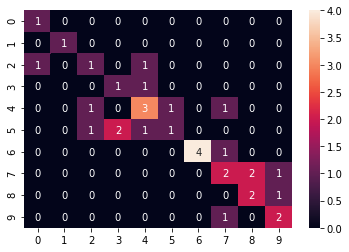


Mean Square Error: 1.5588235294117647

              precision    recall  f1-score   support

           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         1
           3       0.33      0.33      0.33         3
           4       0.50      0.33      0.40         3
           5       0.50      0.50      0.50         6
           6       0.20      0.50      0.29         2
           7       0.80      1.00      0.89         4
           8       0.40      0.40      0.40         5
           9       0.67      0.50      0.57         4
          10       0.67      0.50      0.57         4

    accuracy                           0.53        34
   macro avg       0.61      0.56      0.56        34
weighted avg       0.57      0.53      0.54        34



In [371]:
X_test_scaled = scaler.transform(X.loc[test])
lr_predict = clf.predict(X_test_scaled)
sns.heatmap(confusion_matrix(lr_predict, y.loc[test], labels = range(1,11)), annot=True)
mse = np.sum(np.square(lr_predict - y.loc[test]))/len(lr_predict)
plt.show()
print()
print("Mean Square Error:", mse)
print()
print(classification_report(y.loc[test],lr_predict,labels = range(1,11)))


I did not do cross validation because we don't have a lot of data, some classes don't even have 5 observation